In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from astropy.table import Table
import warnings
warnings.simplefilter("ignore")

- [The Catalog site](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermilgrb&Action=More+Options)
- [Feature key](https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermilgrb.html)

You can check a burst's GBM detectors by putting its name into the [GRB burst catalog](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermigbrst&Action=More+Options) and selecting the data products option "D".

--- 

- FullCatalog.fits holds ALL GRB sources contained in the 2nd Fermi-LAT GRB Catalog
- RS=null.fits holds GRBs which have a null in the redshift parameter
---
\tableofcontents

In [55]:
### Helper functions -- always run this cell

def clean_data(targets):
    # Cleans columns & GRB names
    
    # Remove trailing whitespace
    targets = targets.rename(columns=lambda x: x.strip().lower())
    # Cleans GRB names
    targets['name'] = targets['name'].str.decode("utf-8").replace('\'','').replace(r"^ +| +$", r"", regex=True)[1:]
    return targets

def propagate_error(a, b, e_a, e_b):
    return np.abs(a/b) * np.sqrt( (e_a/a)**2 + (e_b/b) )

def calculate_hardness(targets):
    # Calculates flux, flux_ene & fluence ratios with corresponding error
    targets['flux_ratio'] = targets['like_gbm_flux']/targets['like_lat_flux']
    targets['flux_ene_ratio'] = targets['like_gbm_flux_ene']/targets['like_lat_flux_ene']
    targets['fluence_ratio'] = targets['like_gbm_fluence']/targets['like_lat_fluence']



    targets['flux_ratio_error'] = propagate_error(targets['like_gbm_flux'],
                                                  targets['like_lat_flux'],
                                                  targets['like_gbm_flux_error'],
                                                  targets['like_lat_flux_error'])

    targets['flux_ene_ratio_error'] = propagate_error(targets['like_gbm_flux_ene'],
                                                      targets['like_lat_flux_ene'],
                                                      targets['like_gbm_flux_ene_error'],
                                                      targets['like_lat_flux_ene_error'])

    targets['fluence_ratio_error'] = propagate_error(targets['like_gbm_fluence'],
                                                      targets['like_lat_fluence'],
                                                      targets['like_gbm_fluence_error'],
                                                      targets['like_lat_fluence_error'])
    return targets

def calculate_time_difference(targets):
    # Calculate like & gbm-lle time differences
    targets['like_gbm-lat_time_difference'] = targets['like_gbm_t0'] - targets['like_lat_t0']
    targets['gbm-lle_time_difference'] = targets['gbm_cat_t05'] - targets['lle_t90']
    return targets

# Starting with just RS=null datset

Let's start with the RS=null dataset & take a look at hardness vs. burst duration and angular density.

In [56]:
# Load the RS=null.fits dataset
dat = Table.read('RS=null.fits')
targets = dat.to_pandas()

# Cleaning data
targets = clean_data(targets)
targets = calculate_hardness(targets)
targets = calculate_time_difference(targets)

targets.info()

targets.T.tail(8).T.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Columns: 115 entries, name to gbm-lle_time_difference
dtypes: float64(109), int16(2), object(4)
memory usage: 165.1+ KB


,flux_ratio,flux_ene_ratio,fluence_ratio,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,like_gbm-lat_time_difference,gbm-lle_time_difference
count,179.0,179.0,179.0,128.0,128.0,128.0,186.0,186.0
unique,130.0,130.0,130.0,115.0,115.0,115.0,178.0,142.0
top,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
freq,43.0,43.0,43.0,14.0,14.0,14.0,7.0,11.0


The original method simply extracted all sources with a gbm-lat_time_difference > 0.

In [57]:
original_targets = targets[ targets['like_gbm-lat_time_difference'] > 0 ]

original_targets[['like_gbm-lat_time_difference', 'gbm-lle_time_difference', 
                  'lle_t90', 'fluence_ratio', 'flux_ratio',
         'flux_ene_ratio', 'tl100', 'Like_LAT_GRBIndex'.lower(), 'gbm_cat_t90']].corr()

,like_gbm-lat_time_difference,gbm-lle_time_difference,lle_t90,fluence_ratio,flux_ratio,flux_ene_ratio,tl100,like_lat_grbindex,gbm_cat_t90
like_gbm-lat_time_difference,1.000000,0.883330,0.652774,-0.360266,-0.085024,-0.083995,0.226738,-0.207656,0.177010
gbm-lle_time_difference,0.883330,1.000000,0.368750,-0.113933,-0.331636,-0.260577,-0.126596,-0.282277,-0.111074
lle_t90,0.652774,0.368750,1.000000,-0.678517,0.388889,0.313331,0.549679,-0.092251,0.284909
fluence_ratio,-0.360266,-0.113933,-0.678517,1.000000,-0.571144,-0.488411,-0.353920,-0.648098,0.254352
flux_ratio,-0.085024,-0.331636,0.388889,-0.571144,1.000000,0.973617,0.598289,0.585887,0.170301
flux_ene_ratio,-0.083995,-0.260577,0.313331,-0.488411,0.973617,1.000000,0.453961,0.454122,0.054392
tl100,0.226738,-0.126596,0.549679,-0.353920,0.598289,0.453961,1.000000,-0.166795,0.786650
like_lat_grbindex,-0.207656,-0.282277,-0.092251,-0.648098,0.585887,0.454122,-0.166795,1.000000,-0.247354
gbm_cat_t90,0.177010,-0.111074,0.284909,0.254352,0.170301,0.054392,0.786650,-0.247354,1.000000


There should be a negative correlation between burst duration and corresponding fluence ratio (0927-6505(96)00018-7, Figure 2.)

(-0.75, 8.0)

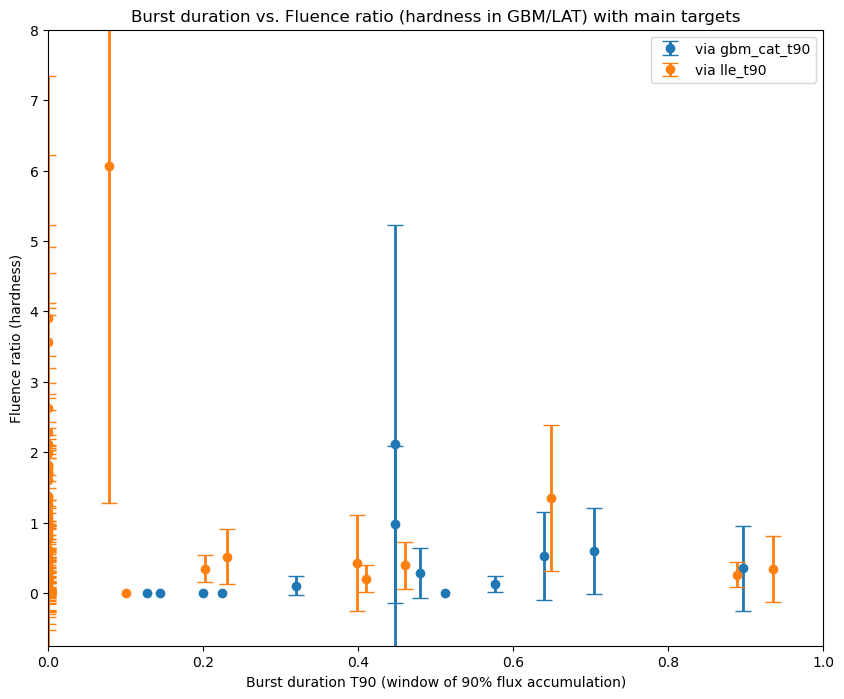

In [58]:
fig, ax = plt.subplots()
ax.errorbar(x = targets['gbm_cat_t90'], y=targets['fluence_ratio'], 
            yerr = targets['fluence_ratio_error'], fmt = 'o', linewidth = 2, capsize = 6, 
            label = 'via gbm_cat_t90')
ax.errorbar(x = targets['lle_t90'], y=targets['fluence_ratio'], 
            yerr = targets['fluence_ratio_error'], fmt = 'o', linewidth = 2, capsize = 6, 
            label = 'via lle_t90')

ax.legend()
ax.set_xlabel('Burst duration T90 (window of 90% flux accumulation)')
ax.set_ylabel('Fluence ratio (hardness)')
fig.set_figwidth(10)
fig.set_figheight(8)
ax.set_title('Burst duration vs. Fluence ratio (hardness in GBM/LAT) with main targets')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(0,1)
ax.set_ylim(-.75,8)

Try to see if the considered correlation does exist by seeing if there's that negative correlation.

In [59]:
# Polyfit does not like NaNs or infs
print('Dropping %s targets for inf fluence_ratio'% len(targets.loc[targets['fluence_ratio'] == np.inf]) )
targets = targets.loc[ targets['fluence_ratio'] != np.inf ]
print('Dropping %s targets for NaN fluence_ratio'% len(targets.loc[ np.isnan(targets['fluence_ratio']) ]) )
targets = targets.loc[ ~np.isnan(targets['fluence_ratio']) ]

# These ones will have had a 0.0 in the LAT flux, causing a NaN
print('Dropping %s targets for NaN fluence_ratio_error'% len(targets.loc[ np.isnan(targets['flux_ratio_error']) ]) )
targets = targets.loc[ ~np.isnan(targets['fluence_ratio_error']) ]

# These ones will have had a 0.0 in GBM flux, causing a 0.
print('Dropping %s targets for 0. fluence_ratio_error'%len(targets[targets['flux_ratio_error'] ==0]))
targets = targets[targets['fluence_ratio_error'] !=0]

Dropping 8 targets for inf fluence_ratio
Dropping 7 targets for NaN fluence_ratio
Dropping 43 targets for NaN fluence_ratio_error
Dropping 14 targets for 0. fluence_ratio_error


Text(0.5, 0.01, 'Fluence ratio ~= hardness wrt. GBM and LAT -- GBM (10 keV - 25 MeV) / LAT (20 MeV - 300 MeV)')

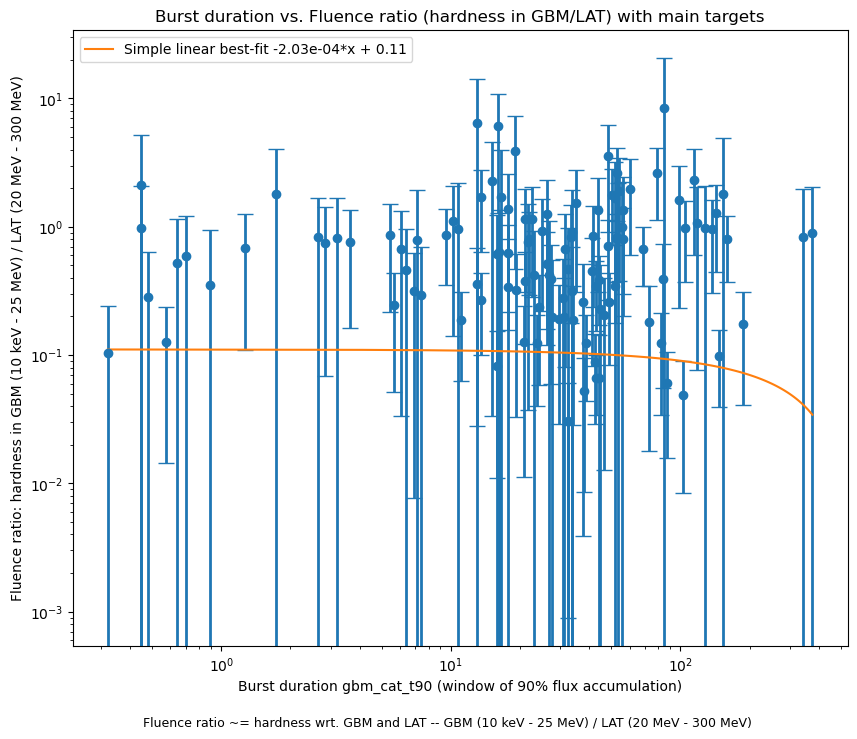

In [60]:
# Fit data with a simple linear correlation
result = np.polyfit(x = targets['gbm_cat_t90'], y = targets['fluence_ratio'], 
                 deg = 1, w = 1/targets['fluence_ratio_error'], full=True)
fit = result[0]

fig, ax = plt.subplots()
ax.errorbar(x = targets['gbm_cat_t90'], y=targets['fluence_ratio'], 
            yerr = targets['fluence_ratio_error'], fmt = 'o', linewidth = 2, capsize = 6)
ax.set_xlabel('Burst duration gbm_cat_t90 (window of 90% flux accumulation)')
ax.set_ylabel('Fluence ratio: hardness in GBM (10 keV - 25 MeV) / LAT (20 MeV - 300 MeV)')
fig.set_figwidth(10)
fig.set_figheight(8)
ax.set_title('Burst duration vs. Fluence ratio (hardness in GBM/LAT) with main targets')
#ax.set_xscale('log')

stats = targets['gbm_cat_t90'].describe()

time_domain = np.linspace(stats['min'], stats['max'], 100)

ax.plot(time_domain, time_domain*fit[0] + fit[1] 
        , '-', label = 'Simple linear best-fit %.2e*x + %.2f'%(fit[0], fit[1]))
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

plt.figtext(0.5, 0.01, 
            'Fluence ratio ~= hardness wrt. GBM and LAT -- GBM (10 keV - 25 MeV) / LAT (20 MeV - 300 MeV)', 
            horizontalalignment='center', fontsize=9)

In [61]:
fig.savefig('Burst_duration_vs_hardness.png')

Time to focus a little on their angular distribution. Since the candidates aren't parsed down, the distribution won't mean too much. I'm curious, though, whether Cline's anomalous overdense region shows up.

In [79]:

def generate_mollweise(targets, log_hardness = False, burst_duration_col='lle_t90'):

    fig = plt.figure()
    ax1 = fig.add_subplot(211, projection='mollweide')
    plt.grid(True)
    ax2 = fig.add_subplot(212, projection='mollweide')
    plt.grid(True)

    # change the >180s to negative
    modified = targets.copy()
    modified.loc[modified['lii']>180, 'lii'] -= (360)

    fig.set_figwidth(20)
    fig.set_figheight(11)
    
    if log_hardness is True:
        modified['fluence_ratio'] = np.log(modified['fluence_ratio'])
        ax1.set_title('log(Hardness): darker  = harder')
    else:
        ax1.set_title('Hardness: darker  = harder')
    ax1.scatter(modified['lii']*(np.pi/180), targets['bii']*(np.pi/180), 50, 
                c=modified['fluence_ratio'], cmap='Greens', edgecolors='lightgray')

    # quick parse-out of the 0 t90s
    nonzeros = targets[ targets[burst_duration_col]!=0.0 ]
    modified = modified[ targets[burst_duration_col]!=0.0 ]

    ax2.set_title('log(1/Burst Duration): darker = shorter')#, rotation=-90, position=(1, .5), ha='left', va='center')
    ax2.scatter(modified['lii']*(np.pi/180), modified['bii']*(np.pi/180), 50, 
                c=np.log10(1/nonzeros[burst_duration_col]), cmap='Greens', edgecolors='lightgray')

    ax1.set_ylabel('Gal. Longitude')
    ax2.set_xlabel('Gal. Latitude')

    plt.figtext(0.5, 0.065, 
                'In Gal. Lat/Long coords, the galactic center is at (0,0) and the plane is on the x-axis.', 
                horizontalalignment='center', fontsize=10)
    return fig

#fig = generate_mollweise(targets)

#fig.savefig('AngularDistribution.png')

---

# Now with the full dataset

Let's try to enforce the same restrictions that Cline did on their BATSE data.

- Hardness >0
- Burst Duration <1s

Also, we need to figure out a way to determine the actual burst duration in the way that Cline did.

In [63]:
# Load the FullCatalog.fits dataset
dat = Table.read('FullCatalog.fits')
targets = dat.to_pandas()

# Cleaning data
targets = clean_data(targets)
targets = calculate_hardness(targets)
targets = calculate_time_difference(targets)

targets.info()

targets.T.tail(8).T.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Columns: 115 entries, name to gbm-lle_time_difference
dtypes: float64(109), int16(2), object(4)
memory usage: 205.0+ KB


,flux_ratio,flux_ene_ratio,fluence_ratio,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,like_gbm-lat_time_difference,gbm-lle_time_difference
count,223.0,223.0,223.0,157.0,157.0,157.0,231.0,231.0
unique,159.0,159.0,159.0,143.0,143.0,143.0,222.0,174.0
top,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
freq,58.0,58.0,58.0,15.0,15.0,15.0,8.0,13.0


In [64]:
# Do we want the ones with the highest hardness value?
print('Sorted by hardness: ')
print(targets[['fluence_ratio', 'name', 'ra', 'dec', 'lle_t90', 'gbm_cat_t90']].loc[targets[
    'fluence_ratio'] != np.inf].sort_values(by='fluence_ratio', ascending=False).head(20))


# I want to get the smallest burst-duration one too
print('\nSorted by LLE burst duration:')
print(targets[ targets['lle_t90']!=0.0 ][[
    'lle_t90', 'name', 'ra', 'dec', 'fluence_ratio', 'gbm_cat_t90']].sort_values(
    by = 'lle_t90', ascending=True).head(20))

print('\nSorted by GBM burst duration:')
print(targets[['gbm_cat_t90', 'name', 'ra', 'dec', 'fluence_ratio', 'lle_t90']].sort_values(
    by = 'gbm_cat_t90', ascending=True).head(20))


Sorted by hardness: 
     fluence_ratio          name       ra     dec  lle_t90  gbm_cat_t90
76        8.433630  GRB100826957  277.710 -25.270   21.087       84.993
174       6.426991  GRB180305393   49.670  32.100    2.894       13.056
90        6.069751  GRB130310840  142.380 -17.100    0.078       16.000
194       4.541625  GRB200613229  153.018  45.886    3.426      478.026
202       3.904246  GRB170306588  154.540  51.550    0.000       18.944
206       3.566120  GRB171102107  187.720  54.010    0.000       48.385
71        3.505726  GRB190114873   54.650 -27.040   41.297      116.354
184       3.308973  GRB160910722  221.310  38.810   10.777       24.320
41        2.627453  GRB170906030  203.940 -47.120    0.000       78.849
199       2.604736  GRB120226871  302.970  48.980   28.926       52.993
225       2.306479  GRB100724029  123.590  75.860   99.807      114.690
171       2.289091  GRB161015710  269.130  30.160    0.000       15.104
228       2.113133  GRB141113346  182.320  

               fluence_ratio   lle_t90  gbm_cat_t90  redshift
fluence_ratio       1.000000 -0.149234    -0.114600 -0.129133
lle_t90            -0.149234  1.000000     0.086757  0.232006
gbm_cat_t90        -0.114600  0.086757     1.000000 -0.075295
redshift           -0.129133  0.232006    -0.075295  1.000000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 2 to 223
Columns: 115 entries, name to gbm-lle_time_difference
dtypes: float64(109), int16(2), object(4)
memory usage: 29.7+ KB
None


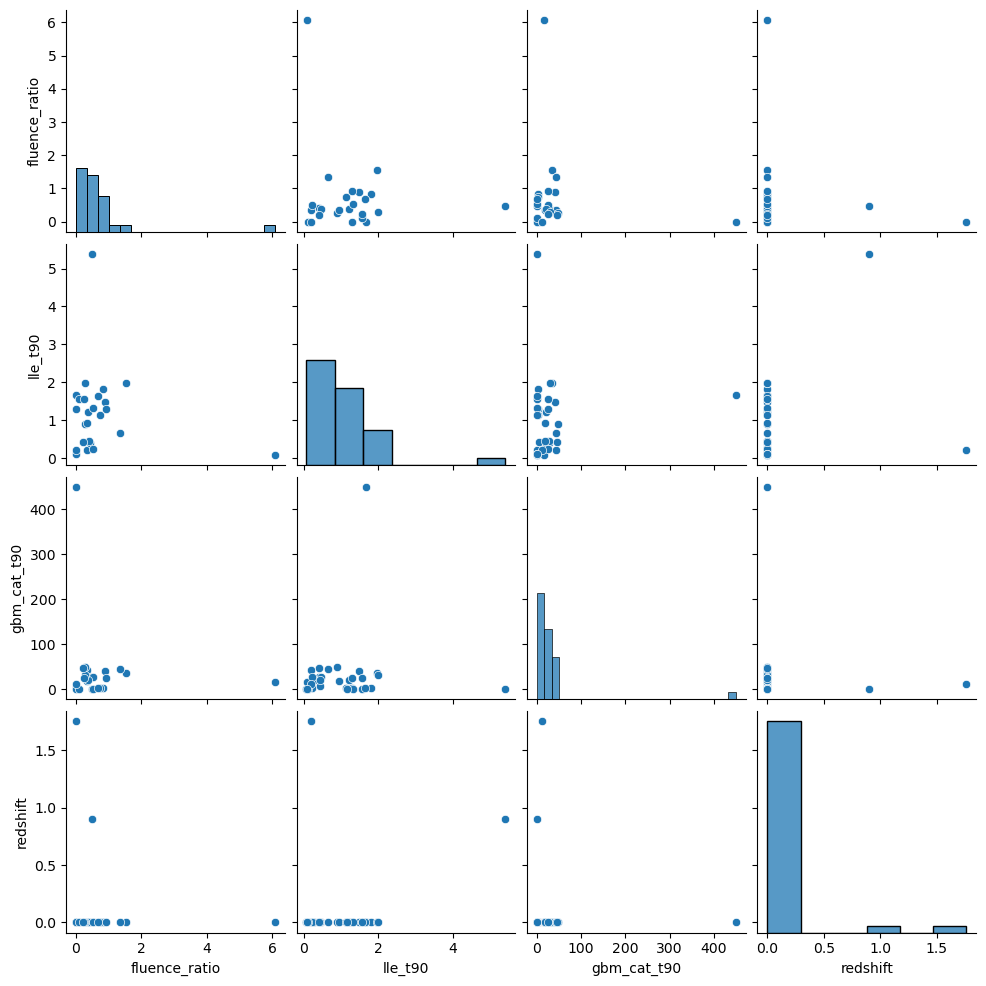

In [65]:
selection = targets.loc[targets['lle_t90']!=0].loc[(targets[['lle_t90', 'gbm_cat_t90']]<2).any(axis=1)]

params = ['name','fluence_ratio', 'lle_t90', 'gbm_cat_t90', 'redshift']

ax = sns.pairplot(selection[params])
print(selection[params].corr())
print(selection.info())

In [66]:
# So we confirm that the t90s correlate relatively well & hardness less-so

# Gonna export these ones so that I can fit them with a powerlaw index & bring it back here.
selection.to_csv('<2s_t90_dataset.csv')

Text(0.5, 0.98, 'All sources with ')

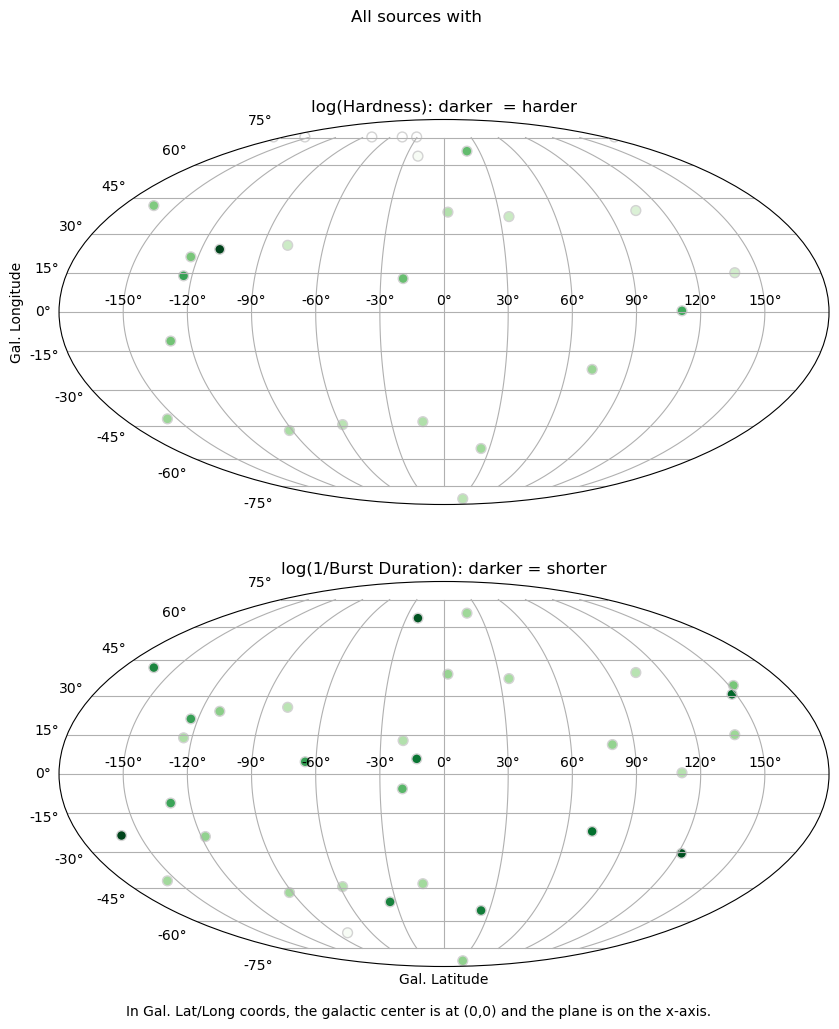

In [80]:
# Generally pretty isotropic, somehow also outside of the galactic plane

fig = generate_mollweise(selection, log_hardness=True, burst_duration_col='gbm_cat_t90')
fig.suptitle('All sources with lle_t90 or gbm_cat_t90 < 1s')

In [78]:
# The ones with decent signal
cols = ['name', 'ra', 'dec', 'lle_t90', 'gbm_cat_t90', 'fluence_ratio', 'like_gbm_ts']

print( targets[cols].loc[ targets['name'] == 'GRB141222298'] )
print( targets[cols].loc[ targets['name'] == 'GRB090227772'] ) 
print( targets[cols].loc[ targets['name'] == 'GRB110529034'] )
print( targets[cols].loc[ targets['name'] == 'GRB131014215'] )


            name     ra    dec  lle_t90  gbm_cat_t90  fluence_ratio  \
25  GRB141222298  178.0 -57.31    1.293        2.752            0.0   

    like_gbm_ts  
25          0.0  
             name    ra   dec  lle_t90  gbm_cat_t90  fluence_ratio  \
175  GRB090227772  11.8  32.2    1.144        0.304            inf   

     like_gbm_ts  
175      23.1253  
             name      ra    dec  lle_t90  gbm_cat_t90  fluence_ratio  \
219  GRB110529034  118.33  67.91    0.093        0.512            inf   

     like_gbm_ts  
219      9.55798  
            name      ra    dec  lle_t90  gbm_cat_t90  fluence_ratio  \
85  GRB131014215  100.78 -20.76    1.811          3.2       0.816955   

    like_gbm_ts  
85      131.946  
